<a href="https://colab.research.google.com/github/naoya1110/ai_robotics_lab_2022_hands_on/blob/main/Week07_Image_Classification_Competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NCKU-NITKC AI Robotics Lab - Week 07

## Introduction
From this week, you are going to work on the image classification competition.

Your mission is to implement a deep neural network model that can classify three different kind of noodles, spaghetti, ramen, and udon with a higher accuracy.

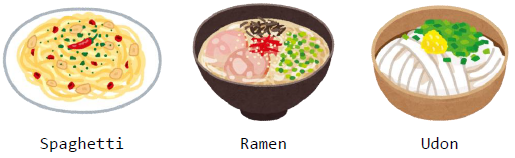


This notebook provides an example of codes for the competition. In order to achive a higher accuracy, your will probably need to implement several techniques that you learned so far.

### GPU

Please make sure your runtime type is GPU (cuda).

In [1]:
import torch

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(device)

cuda


### General Packages

Let's import general Python packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import os
import gdown

## Data Preparation

### Download Data
Unlike CIFAR10 dataset, the data we will be using here are normal JPEG files. Therefore, we have to prepare the dataset so that PyTorch can handle them.

The noodles image data can be downloaded by the code below. Once the downloading is completed you will find `noodles_dataset.zip` in the Files tab on the left side.

In [3]:
gdown.download('https://drive.google.com/uc?id=1twjlztnstRCfWe8GFMUcLVWVFh7CWxAV', 'noodles_dataset.zip', quiet = False)

Downloading...
From: https://drive.google.com/uc?id=1twjlztnstRCfWe8GFMUcLVWVFh7CWxAV
To: /content/noodles_dataset.zip
100%|██████████| 335M/335M [00:02<00:00, 153MB/s]


'noodles_dataset.zip'

Then unzip `noodles_dataset.zip` then you will find `noodles_dataset` directory in the Files tab.

In [4]:
! unzip noodles_dataset.zip > /dev/null 2>&1

There are directories named `train` and `test` in the `noodles_dataset` directory. In the `train` directory, there are sub directories named `0_spaghetti`, `1_ramen` and `2_udon` which contain spaghetti, ramen, and udon images, respectively. In the `test` directory, there is a sub directory named `unknown` that contains spaghetti, ramen and udon images together in random order.

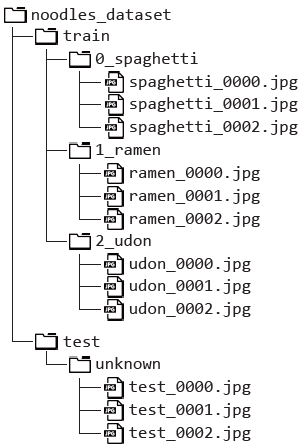

Let's check the number of image files.

In [5]:
for subdir in ["train", "test"]:
    print(subdir)
    subsubdirs = sorted(os.listdir(os.path.join("noodles_dataset", subdir)))
    for subsubdir in subsubdirs:
        filenames = os.listdir(os.path.join("noodles_dataset", subdir, subsubdir))
        print("---", subsubdir, ":", len(filenames))

train
--- 0_spaghetti : 2882
--- 1_ramen : 2788
--- 2_udon : 2789
test
--- unknown : 1000


### Create Dataset
In order to create PyTorch datasets with such tree-structured directories, we can use `torchvision.datasets.ImageFoloder`.

In [7]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="noodles_dataset/train")
test_dataset = ImageFolder(root="noodles_dataset/test")

print("train_dataset:", len(train_dataset))
print("test_dataset:", len(test_dataset))

train_dataset: 8459
test_dataset: 1000


Let's see some "spaghetti" data in the `train_dataset`.

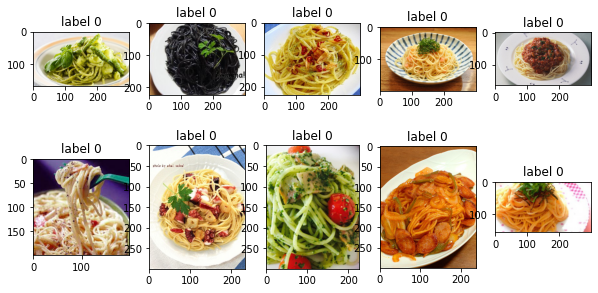

In [12]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}") 

Let's see some "ramen" data in the `train_dataset`.

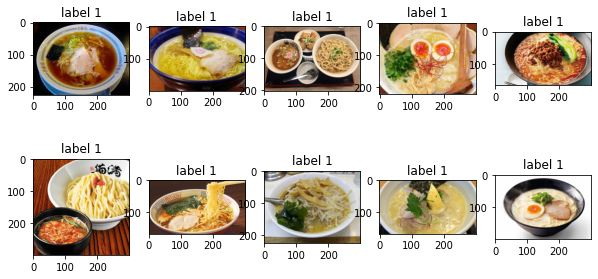

In [13]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i+2882]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}") 

Let's see some "udon" data in the `train_dataset`.

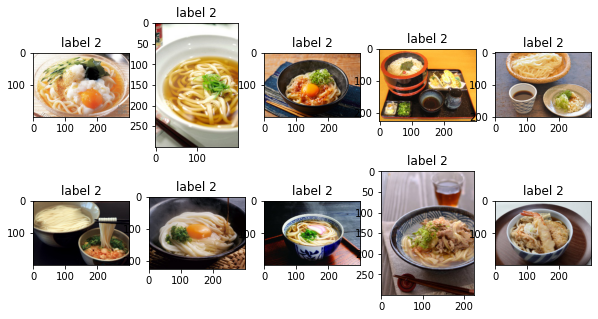

In [14]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = train_dataset[i+2882+2788]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}") 

As you see above, spaghetti, ramen and udon images are labeled as "0", "1" and "2", respectively. 

This labeling is automatically done according to the name of directories in the `train` directory specified in `ImageFolder`. You can check the assigned label numbers as shown below.

In [15]:
train_dataset.class_to_idx

{'0_spaghetti': 0, '1_ramen': 1, '2_udon': 2}

Here we make the classnames dictionary.

In [16]:
classnames = {0:"spaghetti", 1:"ramen", 2:"udon"}
classnames

{0: 'spaghetti', 1: 'ramen', 2: 'udon'}

Let's see some data in `test_dataset`.

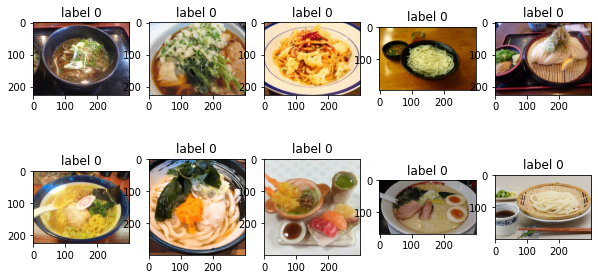

In [19]:
plt.figure(figsize=(10, 5))

for i in range(10):
    image, label = test_dataset[i]
    plt.subplot(2, 5, i+1)
    plt.imshow(image)
    plt.title(f"label {label}") 

 Since there is only one sub directory named `unknow`  in `test` directory, all images are labeled as "0".

In [18]:
test_dataset.class_to_idx

{'unknown': 0}

In order to feed image data to a PyTorch model, all the image data must be in the same shape. Here we resize all of the image data to 96x96 pixels. Also we convert the image data to `torch.tensor` format.

You can also apply other preprocessing such as data standardization and data augmentation here.

In [21]:
from torchvision import transforms

train_dataset = ImageFolder(root="noodles_dataset/train",
                            transform=transforms.Compose([
                                transforms.Resize((96, 96)),
                                transforms.ToTensor()
                                ])
                       )

test_dataset = ImageFolder(root="noodles_dataset/test",
                           transform=transforms.Compose([
                                transforms.Resize((96, 96)),
                                transforms.ToTensor()
                                ])
                      )

### Data Splitting

Since all of the test dataset are labeled as "0", *i.e. not labeled correctly*, we cannot use them for evaluating the trained model. 

Therefore, we have to prepare another dataset for the evaluation. Such dataset are called validation dataset. The validation dataset are usually made by splitting the training dataset. Here we split `train_dataset` into `valid_dataset` and new `train_dataset`.

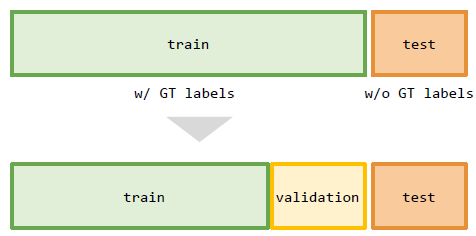

In [22]:
from torch.utils.data import random_split

n_samples = len(train_dataset)
train_size = int(n_samples * 0.7)    # 70% will be training data
valid_size = n_samples - train_size  # 30% will be validation data

train_dataset, valid_dataset = random_split(train_dataset, [train_size, valid_size])

print("train data", len(train_dataset))
print("validation data", len(valid_dataset))

train data 5921
validation data 2538


### DataLoader

Then we create the dataloaders for training, validation and test dataset.

In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=50, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=50, shuffle=False, num_workers=2)

## Model Building

### Model Architecture

You can use any kind of models you want.

Here we just build a simple CNN model as a baseline.

In [24]:
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )

        self.classifier = nn.Sequential(
            nn.Linear(256*12*12, 128),
            nn.ReLU(),
            nn.Linear(128, 3)
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)  
        return x
    
model = Model().to(device)
print(model)

Model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=36864, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=3, bias=True)
  )
)


### torchinfo
Let's see the model archtecture and how the data shape changes in the model.

In [25]:
! pip install torchinfo
from torchinfo import summary

for x_batch, _ in train_loader:
    break

input_shape = x_batch.shape
print(input_shape)

summary(model, input_shape)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
torch.Size([50, 3, 96, 96])


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [50, 3]                   --
├─Sequential: 1-1                        [50, 256, 12, 12]         --
│    └─Conv2d: 2-1                       [50, 64, 96, 96]          1,792
│    └─ReLU: 2-2                         [50, 64, 96, 96]          --
│    └─MaxPool2d: 2-3                    [50, 64, 48, 48]          --
│    └─Conv2d: 2-4                       [50, 128, 48, 48]         73,856
│    └─ReLU: 2-5                         [50, 128, 48, 48]         --
│    └─MaxPool2d: 2-6                    [50, 128, 24, 24]         --
│    └─Conv2d: 2-7                       [50, 256, 24, 24]         295,168
│    └─ReLU: 2-8                         [50, 256, 24, 24]         --
│    └─MaxPool2d: 2-9                    [50, 256, 12, 12]         --
├─Sequential: 1-2                        [50, 3]                   --
│    └─Linear: 2-10                      [50, 128]                 4,718,

## Training

### Loss Function


In [26]:
loss_func = nn.CrossEntropyLoss()

### Optimizer


In [27]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1E-3)

### Training Loop







In [28]:
model = Model().to(device)                             # load model to GPU
loss_func = nn.CrossEntropyLoss()                      # set loss function
optimizer = optim.Adam(model.parameters(), lr=1E-3)    # set optimizer
epochs = 5

# create empty lists for saving metrics during training
train_loss_list = []
train_accuracy_list = []
valid_loss_list = []
valid_accuracy_list = []

for epoch in range(epochs):

    print(f"Epoch {epoch+1}/{epochs}")

    # initialize metrics value
    train_correct_count = 0
    train_accuracy = 0
    train_loss = 0
    valid_correct_count = 0
    valid_accuracy = 0
    valid_loss = 0

    #--- Training Phase ---#
    model.train()    # set model to training mode

    pbar = tqdm(train_loader)
    pbar.set_description("Train")

    for x_batch, y_batch in pbar:      # take mini batch data from train_loader
        
        x_batch = x_batch.to(device)     # load x_batch data on GPU
        y_batch = y_batch.to(device)     # load y_batch data on GPU
    
        optimizer.zero_grad()                  # reset gradients to 0
        p_batch = model(x_batch)               # do prediction
        loss = loss_func(p_batch, y_batch)     # measure loss
        loss.backward()                        # calculate gradients
        optimizer.step()                       # update model parameters

        train_loss += loss.item()                                # accumulate loss value
        p_batch_label = torch.argmax(p_batch, dim=1)             # convert p_batch vector to p_batch_label
        train_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

        pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #----------------------#

    #--- Evaluation Phase ---#
    with torch.no_grad():   # disable autograd for saving memory usage
        model.eval()        # set model to evaluation mode

        pbar = tqdm(valid_loader)
        pbar.set_description("Valid") 

        for x_batch, y_batch in pbar:   # take mini batch data from test_loader

            x_batch = x_batch.to(device)     # load x_batch data on GPU
            y_batch = y_batch.to(device)     # load y_batch data on GPU

            p_batch = model(x_batch)              # do prediction
            loss = loss_func(p_batch, y_batch)    # measure loss

            valid_loss += loss.item()                                # accumulate loss value
            p_batch_label = torch.argmax(p_batch, dim=1)            # convert p_batch vector to p_batch_label
            valid_correct_count += (p_batch_label == y_batch).sum()  # count up number of correct predictions

            pbar.set_postfix({"accuracy":f"{(p_batch_label == y_batch).sum()/len(x_batch):.4f}", "loss": f"{loss.item():.4f}"})
    #------------------------#

    train_accuracy = train_correct_count.item()/len(train_dataset)   # determine accuracy for training data
    valid_accuracy = valid_correct_count.item()/len(valid_dataset)   # determin accuracy for test data
    train_loss = train_loss/len(train_loader)       # determin loss for training data
    valid_loss = valid_loss/len(valid_loader)       # determin loss for validation data 

    # show and store metrics
    print(f"Train: Accuracy={train_accuracy:.3f} Loss={train_loss:.3f}, Valid: Accuracy={valid_accuracy:.3f} Loss={valid_loss:.3f}")
    train_accuracy_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    valid_accuracy_list.append(valid_accuracy)
    valid_loss_list.append(valid_loss)
    
    print("---------------------")

Epoch 1/5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Train: Accuracy=0.546 Loss=0.932, Valid: Accuracy=0.615 Loss=0.847
---------------------
Epoch 2/5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Train: Accuracy=0.609 Loss=0.850, Valid: Accuracy=0.619 Loss=0.829
---------------------
Epoch 3/5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Train: Accuracy=0.644 Loss=0.800, Valid: Accuracy=0.621 Loss=0.815
---------------------
Epoch 4/5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Train: Accuracy=0.665 Loss=0.754, Valid: Accuracy=0.640 Loss=0.793
---------------------
Epoch 5/5


  0%|          | 0/119 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Train: Accuracy=0.694 Loss=0.694, Valid: Accuracy=0.644 Loss=0.813
---------------------


### Learning Curves

Let's visualize the accuracy and the loss curves for training and validation data.

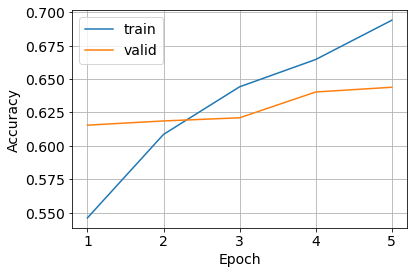

In [29]:
plt.rcParams["font.size"]=14
plt.plot(np.arange(epochs)+1, train_accuracy_list, label="train")
plt.plot(np.arange(epochs)+1, valid_accuracy_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid()
plt.legend()

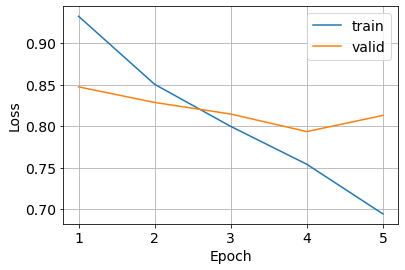

In [30]:
plt.plot(np.arange(epochs)+1, train_loss_list, label="train")
plt.plot(np.arange(epochs)+1, valid_loss_list, label="valid")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

## Evaluation

You may want to do some evaluations with the validation data.

## Submission

### Making Submission File
Now we make predictions for all the test data.

In [31]:
### DO NOT CHANGE ### 

p_label_all = np.array([])

with torch.no_grad():
    model.eval()

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        p_batch = model(x_batch)
        p_batch_label = torch.argmax(p_batch, dim=1)
        p_label_all = np.append(p_label_all, p_batch_label.to("cpu").numpy())

p_label_all = p_label_all.astype("uint8")
print(p_label_all)

[2 2 0 1 2 1 1 0 1 2 0 1 1 1 2 1 1 1 2 1 0 1 0 0 2 1 2 1 1 1 1 0 1 1 2 1 2
 1 2 1 2 1 2 0 2 1 0 2 1 2 2 1 2 2 2 2 1 2 0 1 0 2 2 0 1 0 1 1 1 1 1 2 2 1
 0 0 1 0 1 1 2 0 2 2 1 1 2 2 2 2 2 2 1 2 1 1 0 1 1 1 1 1 2 1 1 1 2 0 1 0 1
 1 2 2 0 0 2 2 1 1 0 2 2 2 2 1 0 0 2 0 0 0 2 1 1 2 1 0 1 0 1 1 2 1 2 1 2 1
 0 2 0 2 0 0 2 1 1 1 2 0 2 2 2 1 2 1 1 1 1 0 0 1 2 0 1 1 2 1 1 0 2 2 0 0 2
 1 1 2 2 2 2 2 1 2 2 1 1 1 2 0 1 1 2 1 2 2 2 2 2 0 1 0 1 2 0 0 0 0 2 2 0 1
 1 1 1 2 1 0 2 1 1 1 1 1 0 2 2 1 2 0 2 1 1 0 1 0 2 1 0 2 1 2 2 1 0 2 1 0 2
 1 2 1 1 2 1 1 2 0 1 1 2 0 1 2 1 1 2 2 2 1 1 1 0 1 0 2 0 2 2 1 0 2 2 1 0 2
 2 1 2 1 0 2 1 2 1 0 2 1 1 2 2 1 2 2 2 2 2 2 0 1 0 1 1 2 1 1 1 2 0 2 2 2 1
 0 0 0 1 2 2 2 0 1 2 1 1 0 1 0 1 1 0 0 1 1 2 1 2 2 1 1 2 2 2 2 0 2 2 2 2 2
 2 1 1 0 2 2 0 2 1 2 1 2 0 0 1 1 1 2 0 2 2 2 2 2 2 2 1 0 0 1 1 1 0 0 1 2 1
 1 0 2 2 2 1 0 2 1 2 1 1 2 1 1 0 1 2 2 2 2 2 1 1 1 1 2 2 1 0 1 2 2 1 1 2 1
 1 1 1 1 1 0 1 0 0 0 2 1 1 1 0 1 2 0 1 0 2 2 0 0 2 1 1 1 1 0 2 2 1 2 1 0 1
 2 1 2 2 2 1 2 2 1 2 0 1 

Please set your `team_id` and `username` here.

In [32]:
team_id = 0
username = "yourname"

Now we create a submission file named `{team_id}_{username}_submission.csv`.

In [37]:
### DO NOT CHANGE ### 

df_submit = pd.DataFrame()
df_submit["id"] = np.arange(1000)
df_submit["label"] = p_label_all

submission_file_name = f"{str(team_id).zfill(2)}_{username}_submission.csv"

df_submit.to_csv(submission_file_name, index = False)

print(submission_file_name)
df_submit

00_yourname_submission.csv


,id,label
0,0,2
1,1,2
2,2,0
3,3,1
4,4,2
...,...,...
995,995,0
996,996,0
997,997,2
998,998,1


### Submission Form

Now you can find your submission file `{team_id}_{username}_submission.csv` in the Files tab. Please download it to your local disk and submit it from the submission form below.

https://forms.gle/bhdoSvAoNmYqAT4N6

**Important** 

*   You can make submissions as many as you want. But only the latest submission is valid for the competition ranking.
*   The evaluation will not be performed immediately after your submission. Naoya will run the evaluation code a couple of times everyday.

### Leaderboard

You can check your current score and ranking.

In [35]:
import gdown
import pandas as pd 
import os

gdown.download('https://drive.google.com/uc?id=1cw3ccdK5rrJjtbLIZHiLo-gxfMgl640V', 'noodles_ranking.csv', quiet = False)
df_ranking = pd.read_csv("/content/noodles_ranking.csv")
os.remove("/content/noodles_ranking.csv")

df_ranking.head(100)

Downloading...
From: https://drive.google.com/uc?id=1cw3ccdK5rrJjtbLIZHiLo-gxfMgl640V
To: /content/noodles_ranking.csv
100%|██████████| 264/264 [00:00<00:00, 90.8kB/s]


,Rank,TeamID & Name,Accuracy,Submission (Taiwan),Submission (Japan)
0,1,01_naoya,0.683,10/14 12:53:09,10/14 13:53:09
1,2,00_iwamoto,0.656,10/14 12:58:11,10/14 13:58:11
2,3,00_naoya,0.653,10/13 21:02:03,10/13 22:02:03
3,4,00_yourname,0.645,10/18 09:40:27,10/18 10:40:27


## Conclusion

That's it for this week. Try your best for the image classification competition!